In [45]:
from IPython.core.debugger import set_trace

DATA_FREQUENCY = 500
SAMPLING_RATE = 5
FREQUENCY_TO_SAMPLING_RATIO = DATA_FREQUENCY / SAMPLING_RATE

In [46]:
import numpy as np
import os

def parse_file(file):
    lines = file.split('\n')
    headers = lines[0].split('\t')
    # to one before last because the last one is empty
    data = lines[1:-1]

    number_of_lines = len(data)
    number_of_lines_after_sampling = number_of_lines // SAMPLING_RATE

    float_data = np.zeros((number_of_lines, len(headers)))
    for line_number, line in enumerate(data):
        values = [float(value) for value in line.split('\t')]
        float_data[line_number, :] = values
    
    return (float_data[::SAMPLING_RATE], headers)

def read_input_files(end, data_path):
    input_path = os.path.join(data_path, 'input_500Hz/sick')
    input_file_names = os.listdir(input_path)
    input_file_names.sort(key=int)

    start = None
    
    files_content = []
    for file_name in input_file_names[start:end]:
        file_path = os.path.join(input_path, file_name)
        file = open(file_path, 'r')
        (columns, headers) = parse_file(file.read())
        print('Loaded input file:', file_name)
        file.close()
        files_content.append(columns)
    print('--Input files loaded--')
    return (files_content, headers)

def create_target_index(value):
    value = int(value)
    return int(value * FREQUENCY_TO_SAMPLING_RATIO)

def read_target_files(end, data_path):
    targets_path = os.path.join(data_path, 'targets')
    targets_file_name = os.listdir(targets_path)[0]
    targets_file_path = os.path.join(targets_path, targets_file_name)

    file = open(targets_file_path, 'r')
    targets_content = file.read()
    file.close()

    # last line is empty
    lines = targets_content.split('\n')[:-1]
    targets = []
    for number, line in enumerate(lines, 1):
        targets.append([(int(value), create_target_index(value)) for value in line.split(',')])
    print('--Target files loaded--')
    return targets[:end]

def read_data(end):
    data_path = 'data'
    (input_data, headers) = read_input_files(end, data_path)
    targets_data = read_target_files(end, data_path)
    
    return (input_data, targets_data, headers)

In [47]:
import random

def create_chunks_with_seizures(patient_data, seizure_seconds, chunk_size):
    number_of_chunks = len(seizure_seconds)
    #     16 when without time
    chunks_input = np.zeros((number_of_chunks, chunk_size, 17))
    chunks_target = np.zeros(number_of_chunks)
    
    for seizure_number in range(0, number_of_chunks):
        (seizure_time, seizure_index) = seizure_seconds[seizure_number]
        chunk_start_index = seizure_index
        chunk_end_index = chunk_start_index + chunk_size
        chunks_input[seizure_number] = patient_data[chunk_start_index:chunk_end_index, :]
        # seizure
        chunks_target[seizure_number] = 1
        
    return (chunks_input, chunks_target)

def is_in_seizure_range(index, seizure_seconds, chunk_size):
    for (seizure_time, seizure_index) in seizure_seconds:
        seizure_start_index = seizure_index
        seizure_end_index = seizure_start_index + chunk_size
        if index in range(seizure_start_index, seizure_end_index):
            return True
    
    return False

def create_non_seizure_data_start_index(data_size, chunk_size, seizure_seconds):
    start_index = random.randint(0, data_size - chunk_size)
    
    while (is_in_seizure_range(start_index, seizure_seconds, chunk_size)):
        start_index = random.randint(0, data_size - chunk_size)
    
    return start_index
    

def create_chunks_without_seizures(patient_data, seizure_seconds, chunk_size):
    number_of_chunks = len(seizure_seconds)
#     16 when without time
    chunks_input = np.zeros((number_of_chunks, chunk_size, 17))
    chunks_target = np.zeros(number_of_chunks)
    (data_size, channels) = patient_data.shape
    
    for chunk_number in range(0, number_of_chunks):
        chunk_start_index = create_non_seizure_data_start_index(data_size, chunk_size, seizure_seconds)
        
        chunk_end_index = chunk_start_index + chunk_size
        chunks_input[chunk_number] = patient_data[chunk_start_index:chunk_end_index, :]
        # non-seizure
        chunks_target[chunk_number] = 0
        
    return (chunks_input, chunks_target)

def prepare_chunks(input, target, chunk_size):
    chunks_input = []
    chunks_target = []
    
    for patient_number in range(0, len(input)):
        patient_chunks_input = []
        patient_chunks_target = []
        seizure_seconds = target[patient_number]
        patient_data = input[patient_number]
        (seizure_chunks_input, seizure_chunks_target) = create_chunks_with_seizures(patient_data, 
                                                                                    seizure_seconds, 
                                                                                    chunk_size)
        patient_chunks_input.extend(seizure_chunks_input)
        patient_chunks_target.extend(seizure_chunks_target)
        
        (non_seizure_chunks_input, non_seizure_chunks_target) = create_chunks_without_seizures(patient_data, 
                                                                                               seizure_seconds,
                                                                                               chunk_size)
        patient_chunks_input.extend(non_seizure_chunks_input)
        patient_chunks_target.extend(non_seizure_chunks_target)
        
        chunks_input.append(np.array(patient_chunks_input))
        chunks_target.append(np.array(patient_chunks_target))
    
    return (np.array(chunks_input), np.array(chunks_target))

In [48]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [20, 5]

def draw_plots(input, target, headers, patient, end_second, start_second=0):
    patient_columns = input[patient]
    targets = target[patient]
    time_column = patient_columns[:, -1]
    channel_columns = patient_columns[:, :-1]
    (rows, columns) = channel_columns.shape
    
    for column in range(columns):
        channel = channel_columns[:, column]
        plt.figure(column)
        plt.xlabel('Seconds')
        plt.ylabel('Value')
        plt.title(headers[column])
        start = start_second * SAMPLING_RATE
        end = end_second * SAMPLING_RATE
        plt.plot(time_column[start:end], channel[start:end])
        draw_targets_in_range(targets, start_second, end_second)
        
def draw_targets_in_range(targets, start_second, end_second):
    for (target, target_index) in targets:
        if (target >= start_second) and (target <= end_second):
            plt.axvline(x=target, color='r')

In [49]:
#draw chosen chunks
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [20, 5]

def draw_plots_with_chunks(input, target, headers, patient, chunks_input, to_pdf=False):
    patient_columns = input[patient]
    targets = target[patient]
    time_column = patient_columns[:, -1]
    channel_columns = patient_columns[:, :-1]
    (rows, columns) = channel_columns.shape
    chunks_input = chunks_input[patient]
    
    for column in range(columns):
        channel = channel_columns[:, column]
        plt.figure(column)
        plt.xlabel('Seconds')
        plt.ylabel('Value')
        plt.title(headers[column])
        plt.plot(time_column, channel)
        draw_targets(targets)
        draw_chunks_start(chunks_input)
        if to_pdf:
            plt.savefig("chanel-{}.pdf".format(column), bbox_inches='tight')
        
def draw_targets(targets):
    for (target, target_index) in targets:
        plt.axvline(x=target, color='r')

def draw_chunks_start(chunks_input):
    for chunk_number in range(0, len(chunks_input)):
        chunk = chunks_input[chunk_number]
        
        plt.axvline(x=chunk[0, -1], color='b', linestyle="--")

In [50]:
(input, target, headers) = read_data(end=1)
(chunks_input, chunks_target) = prepare_chunks(input, target, chunk_size=4 * 100)

Loaded input file: 1
--Input files loaded--
--Target files loaded--


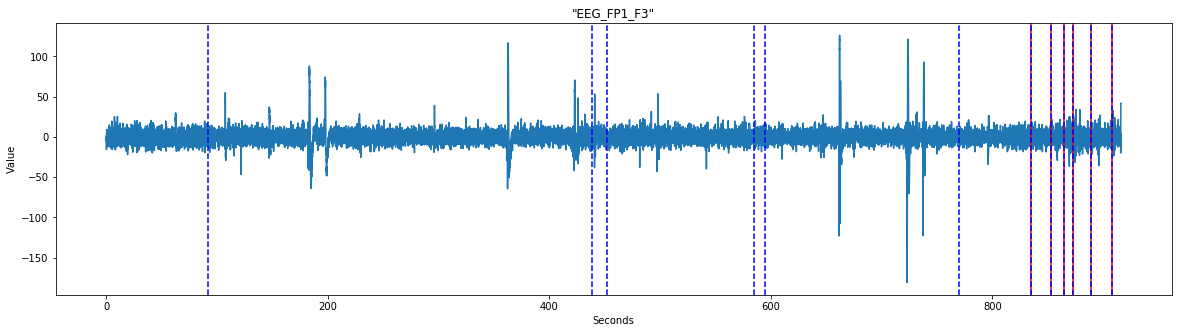

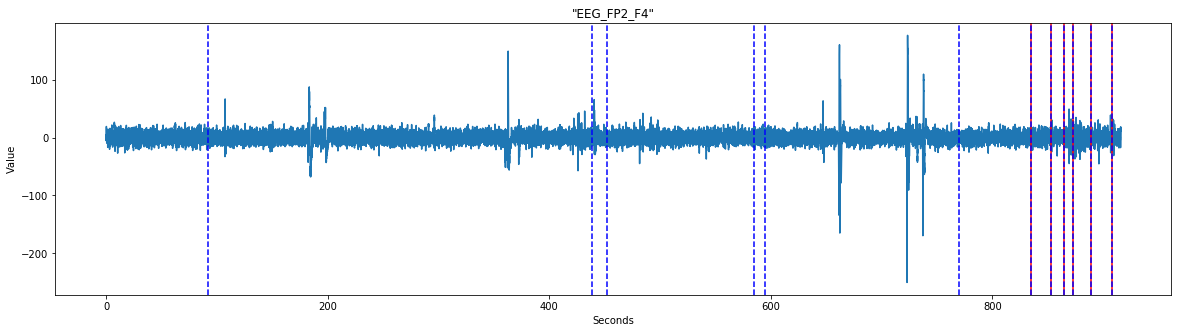

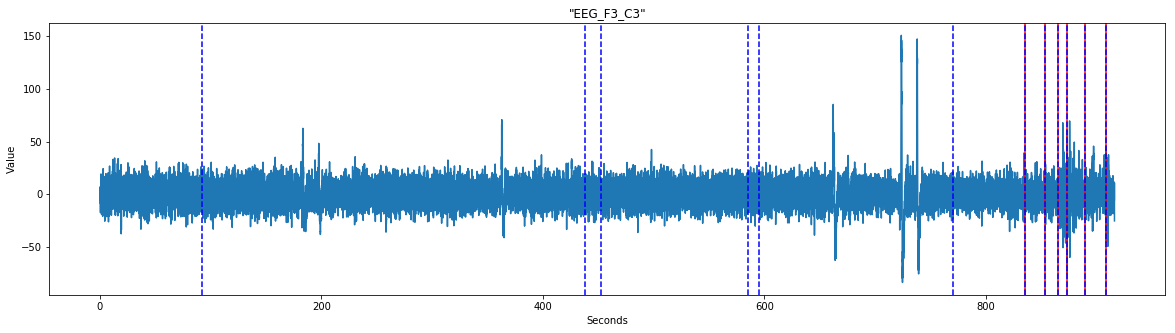

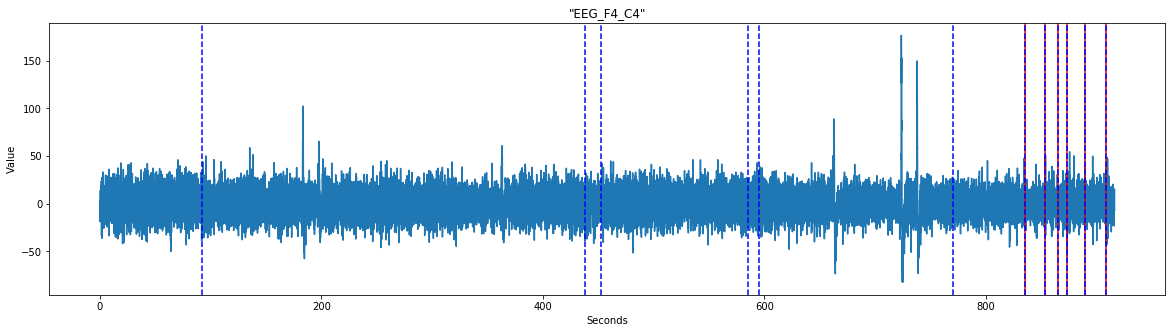

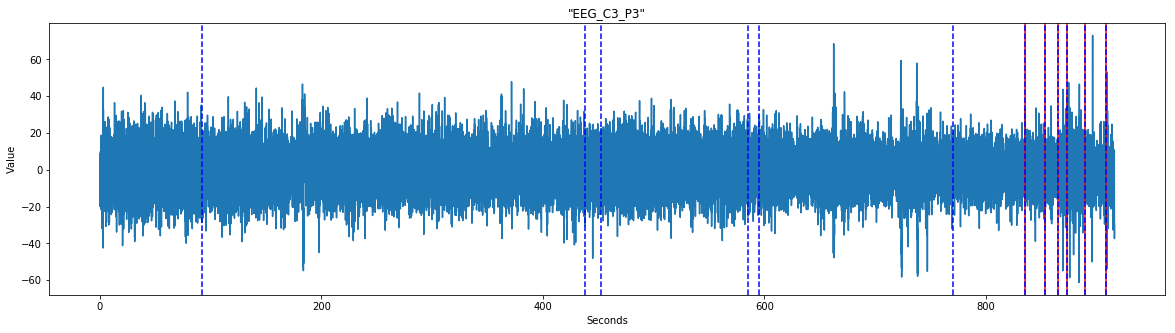

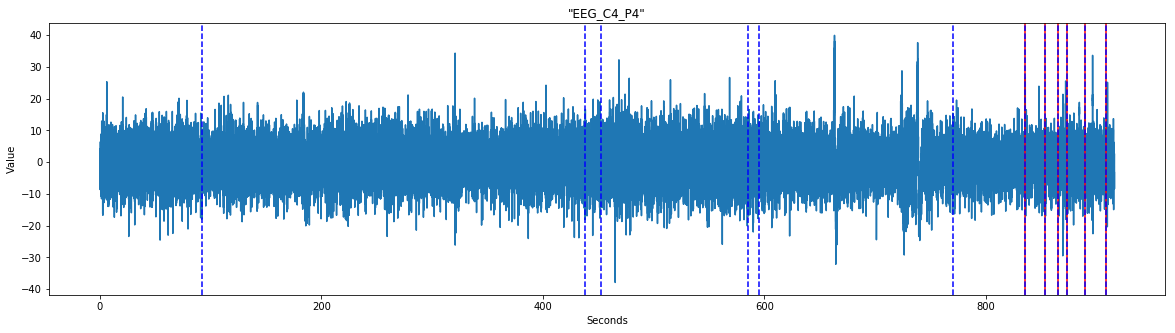

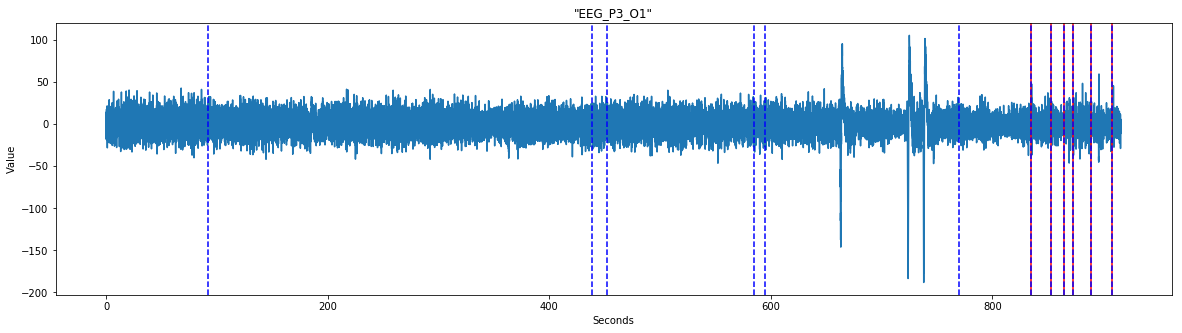

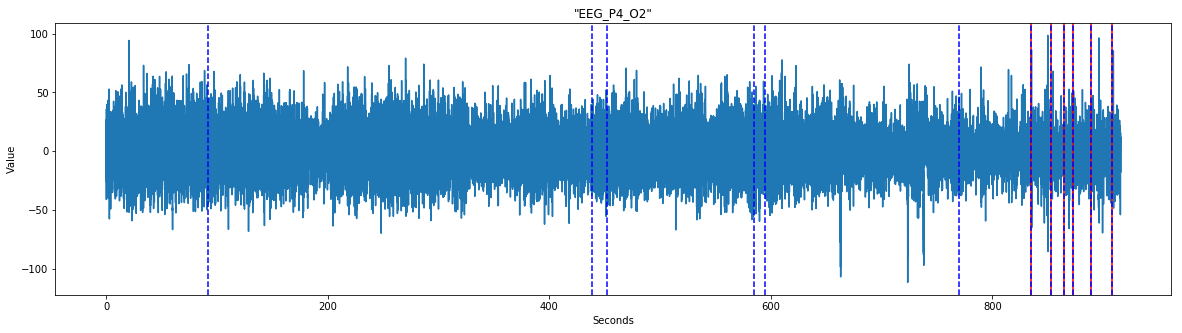

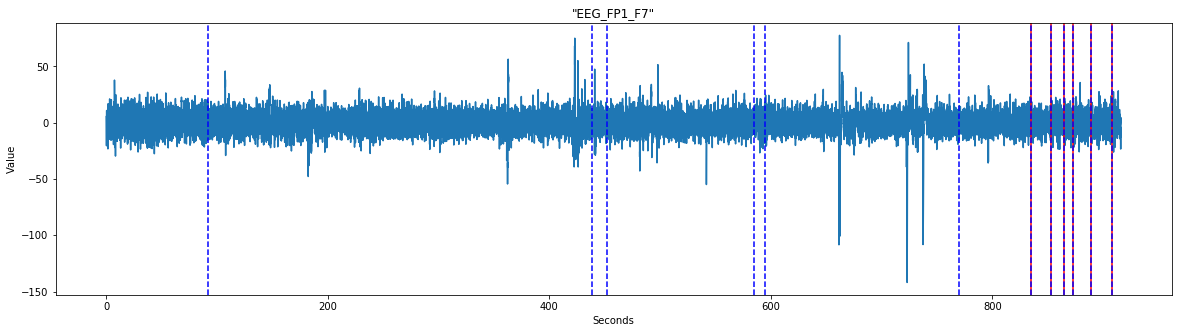

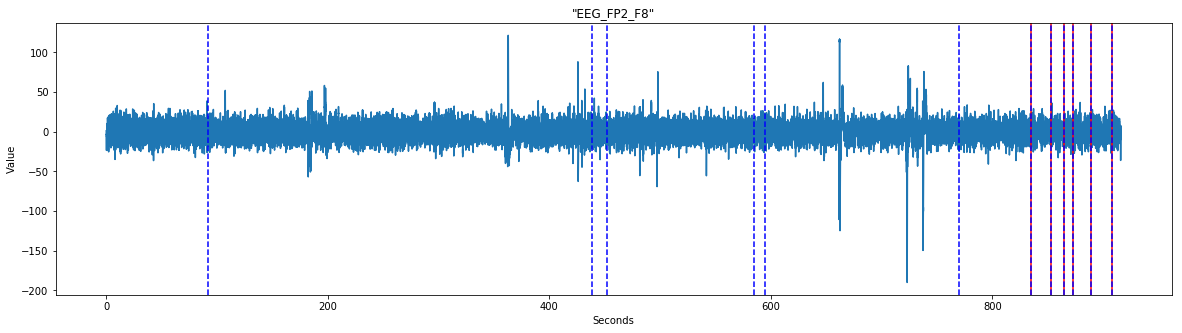

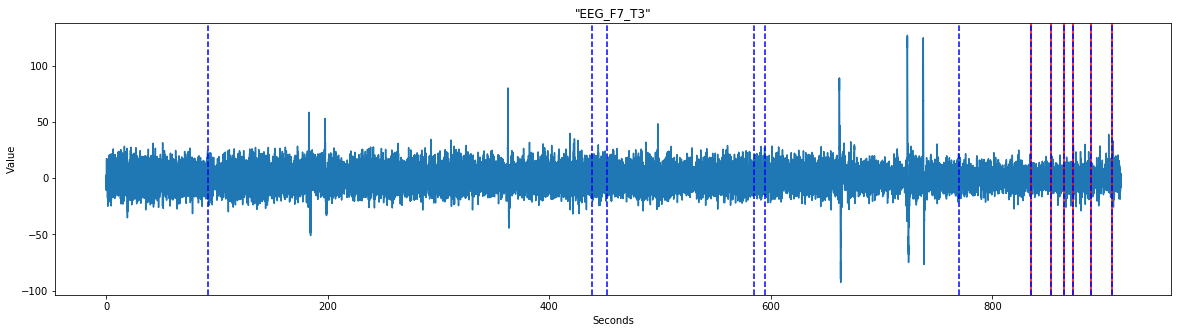

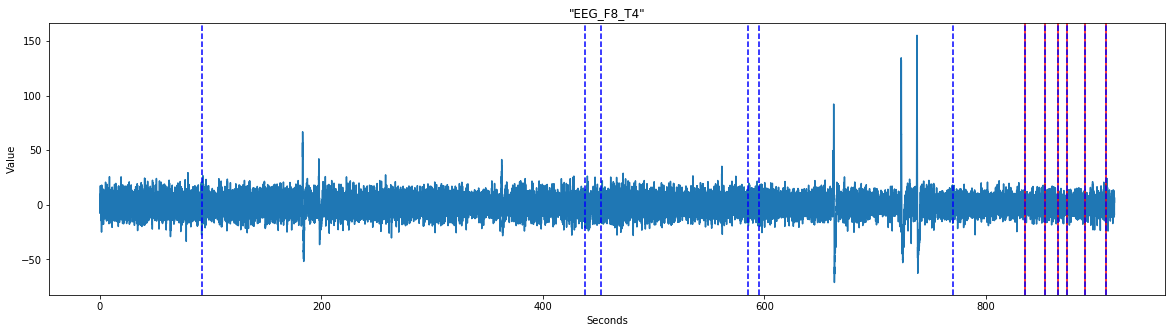

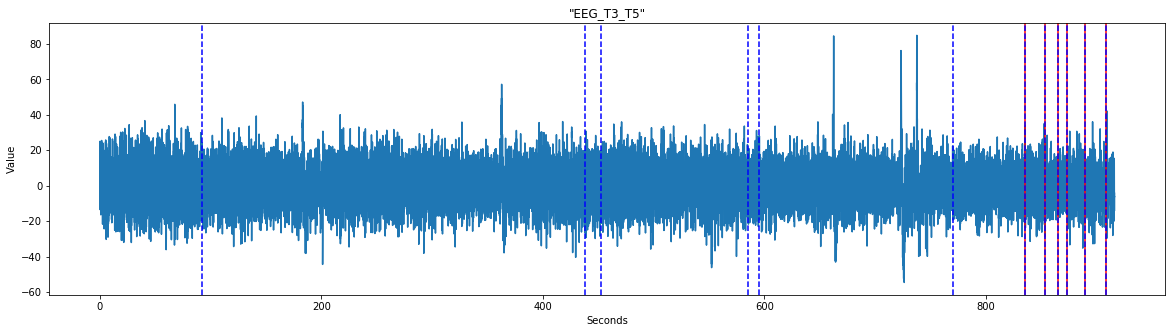

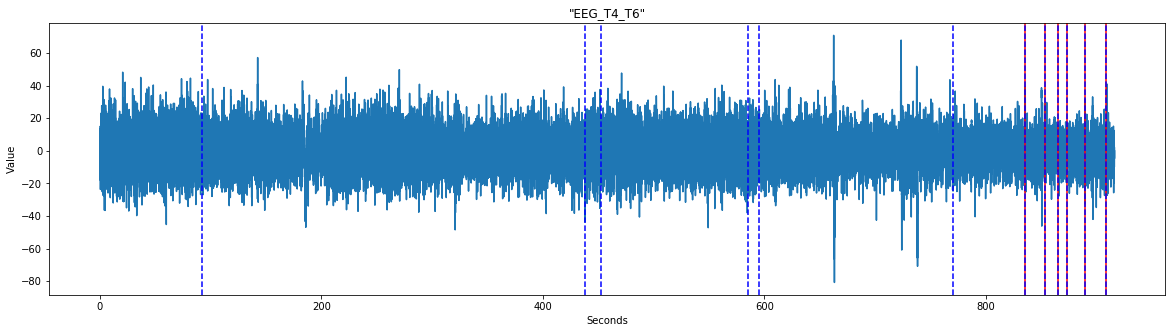

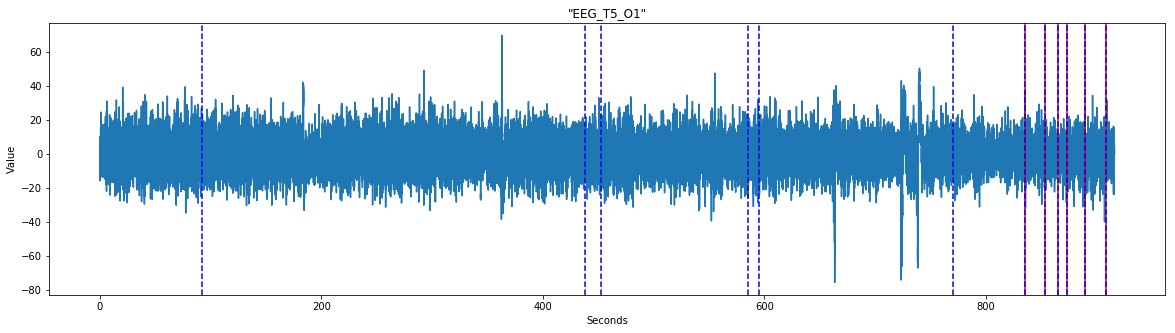

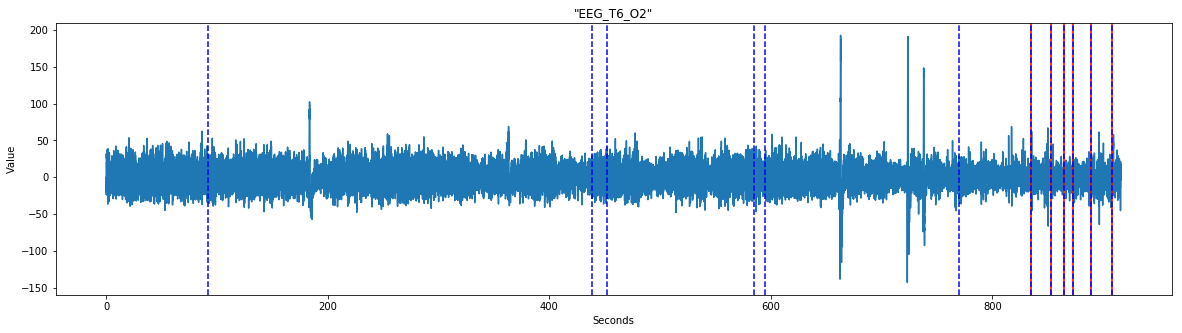

In [51]:
#draw_plots(input, target, headers, patient=0, start_second=900, end_second=910)
draw_plots_with_chunks(input, target, headers, patient=0, chunks_input = chunks_input, to_pdf=False)

In [55]:
patient = 0
chunk = 9
row = 0
print(chunks_input[patient][chunk].shape)
print('time', chunks_input[patient][chunk][row][-1])
print('values', chunks_input[patient][chunk][row][:])

(400, 17)
time 594.69
values [   8.9737   10.4037    5.4582   21.2787   -4.7043   -7.5198    7.9702
   -9.3773    3.4008   21.2265    3.7653    1.7478    2.2177   -6.2284
    8.3198   -1.9646  594.69  ]


In [57]:
print(target[0])
print(input[0][59469])

[(835, 83500), (853, 85300), (865, 86500), (873, 87300), (889, 88900), (908, 90800)]
[   8.9737   10.4037    5.4582   21.2787   -4.7043   -7.5198    7.9702
   -9.3773    3.4008   21.2265    3.7653    1.7478    2.2177   -6.2284
    8.3198   -1.9646  594.69  ]
